In [2]:
from datetime import datetime
from datetime import timedelta
import shapefile
import xml.etree.ElementTree as ET
import numpy as np
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import matplotlib.pyplot as plt
from pyproj import Proj, transform
from pymongo import MongoClient
from sklearn import tree
import os
%matplotlib inline

In [69]:
shp='/media/amassaro/external_2T/telecom_bigdata_2015/data/tim_grid/roma-grid/intersection_Roma_W_GRIDIT_NEW'
crt=shapefile.Reader(shp)
geomet=crt.shapeRecords()
inProj = Proj(init='epsg:32632')
outProj = Proj(init='epsg:4326')

grid=[]
for g in geomet:
    item=[]
    for c in g.shape.points:  
        x2,y2 = transform(inProj,outProj,c[0],c[1])
        item.append([x2,y2])
    grid.append(item)
    
    
grid=np.array(grid)

grid_ids=np.array([g.record[0] for g in geomet])

In [78]:
tree = ET.parse('/media/amassaro/external_2T/telecom_bigdata_2015/data/external_data/xml_incidenti_mar-apr_2015.xml')
root=tree.getroot()
child=list(root)[1]
acc_times=[]
latlong_acc=[]
for j in child:
    if 'Latitudine' in j.attrib.keys() and 'Longitudine' in j.attrib.keys():
        latlong_acc.append([float(j.attrib['Longitudine']),float(j.attrib['Latitudine'])])
        acc_times.append(j.attrib['DataOraIncidente'])


acc_times=np.array([datetime.strptime(t[:10]+' '+t[11:],'%Y-%m-%d %H:%M:%S') for t in acc_times])
latlong_acc=np.array(latlong_acc)

# accidents

In [79]:
start=datetime(2015,3,1)
end=datetime(2015,5,1)
for divide in [2,3,4,6]:    
    n_timesteps=int(((end-start).total_seconds()/3600)/divide)
    timesteps=[start+i*timedelta(0,3600*divide) for i in range(n_timesteps)]
    data=np.zeros([len(grid),n_timesteps])
    for i  in range(len(grid)):
        for j in range(len(latlong_acc)):
            if Polygon(grid[i]).contains(Point(latlong_acc[j])):
                timestep=int((acc_times[j]-start).total_seconds()/(3600*divide))
                data[i,timestep]+=1  
                

    out=open('accidents_by_cell_'+str(divide)+'hour_day','w')
    out.write('grid_id,datetime,'+str(divide)+'hour,weekday,accidents\n')
    for i in range(len(grid)):
        current_date=start
        for t in range(n_timesteps):
            out.write(str(grid_ids[i])+','+str(current_date)+','+str(current_date.hour/divide)+','+str(current_date.weekday())+','+str(data[i,t])+'\n')
            current_date+=timedelta(0,3600)*divide
    out.close()


# floating car

In [ ]:
start=datetime(2015,3,1,0)
end=datetime(2015,5,1,0)
timestep=3600
n_timeslots=int((end-start).total_seconds()/timestep+1)
dt=timedelta(0,timestep)
traffic=np.zeros(n_timeslots)

db=MongoClient()
dbs=np.sort([x for x in db.database_names() if 'fl_car_roma' in x])

for current_db in dbs:
    cur=db[current_db]['floating_car_data'].find()
    for c in cur:
        t=c['timestamp']
        if t>=start and t<=end:
            traffic[int(((t-start).total_seconds())/timestep)]+=1
    print current_db
out=open('total_fl_car_traffic','w')
dt=timedelta(0,timestep)
for i in range(len(traffic)):
    out.write(str(start+i*dt)+','+str(traffic[i])+',\n')
out.close()

# weather

In [4]:
import json
start=datetime(2015,3,1,0)
end=datetime(2015,5,1,0)

chosen=[]
for x in os.listdir('/media/amassaro/external_2T/openweather/Roma/'):
    y=x.split('_')
    d1=datetime.fromtimestamp(int(y[2]))
    d2=datetime.fromtimestamp(int(y[3]))
    if d1.year==2015 and (d1.month==3 or d1.month==4 or d2.month==3 or d2.month==4):
        chosen.append(x)


t=[]
ids=[]
mains=[]
des=[]
for f in chosen:
    with open('/media/amassaro/external_2T/openweather/Roma/'+f) as data_file:    
        data = json.load(data_file)
        for d in data['list']:
            time=datetime.fromtimestamp(d['dt'])
            if time>=start and time<end:
                t.append(time)
                ids.append(d['weather'][0]['id'])
                mains.append(d['weather'][0]['main'])
                des.append(d['weather'][0]['description'])
t=np.array(t)  
T=np.array([tt.replace(minute=0, second=0) if tt.minute<30 else (tt+timedelta(0,3600)).replace(minute=0,second=0) for tt in t])
TT=np.sort(np.array(list(set(T))))

iids=[-1 for i in range(len(TT))]
mmains=[-1 for i in range(len(TT))]
ddes=[-1 for i in range(len(TT))]
k=0
for tt in TT:
    i=np.where(T==tt)[0][0]
    iids[k]=ids[i]
    mmains[k]=mains[i]
    ddes[k]=des[i]
    k+=1
    
out=open('weather','w')
out.write('time,id,main,des,\n')
for i in range(len(TT)):
    out.write(str(TT[i])+','+str(iids[i])+','+str(mmains[i])+','+str(ddes[i])+',\n')
out.close()


# Telco

In [10]:
start=datetime(2015,3,1,0)
end=datetime(2015,5,1,0)
timestep=3600
n_timeslots=int((end-start).total_seconds()/timestep+1)

In [9]:
telco=np.zeros((4,n_timeslots))
dbs=['call_in_roma','call_out_roma','sms_in_roma','sms_out_roma']
coll=['callIn','callOut','smsIn','smsOut']
for i in range(len(dbs)):
    cl=MongoClient()
    db=cl[dbs[i]]
    cur=db[coll[i]].find()
    for c in cur:
        t=datetime.fromtimestamp(c['time_interval'])
        if i<2:
            v=c['n_of_calls']
        else:
            v=c['n_of_sms']
        telco[i,int(((t-start).total_seconds())/timestep)]+=v
    print dbs[i], 'ok'
    cl.close()
for i in range(len(coll)):
    out=open(coll[i],'w')
    for j in range(len(telco[i])):
        out.write(str(start+j*timedelta(0,timestep))+','+str(telco[i,j])+',\n')
    out.close()

call_in_roma ok
call_out_roma ok
sms_in_roma ok
sms_out_roma ok


# Telco by cell_id

In [ ]:
dbs=['call_in_roma','call_out_roma','sms_in_roma','sms_out_roma']
coll=['callIn','callOut','smsIn','smsOut']
cells_list=[db[c].distinct('square_id') for c in coll]
cells=[]
cl=MongoClient()
for i in range(len(dbs)):
    cells+=cl[dbs[i]][coll[i]].distinct('square_id')
cells=list(set(cells))
cl.close()

for cell in cells:
    telco=np.zeros((len(coll),n_timeslots))
    for i in range(len(dbs)):
        cl=MongoClient()
        cur=cl[dbs[i]][coll[i]].find({'quare_id':cell})
        for c in cur:
            t=datetime.fromtimestamp(c['time_interval'])
            if i<2:
                v=c['n_of_calls']
            else:
                v=c['n_of_sms']
            telco[i,int(((t-start).total_seconds())/timestep)]+=v
        cl.close()
    for j in range(len(coll)):
        out=open(coll[j]+'by_cell','a')
        for k in range(len(telco[j])):
            out.write(cell,str(start+k*timedelta(0,timestep))+','+str(telco[j,k])+',\n')
        out.close()

# Distinct floating cars, broken down by type

In [90]:
cats=[]
for current_db in dbs:
    cats+=db[current_db]['floating_car_data'].distinct("vehicle_cat")
cats=list(set(cats))
print cats

[40, 50, 20, 10]


In [91]:
end=datetime(2015,5,1,0)
timestep=3600
dt=timedelta(0,timestep)
db=MongoClient()
dbs=np.sort([x for x in db.database_names() if 'fl_car_roma' in x])

for cat in cats:
    start=datetime(2015,3,1,0)
    H=np.zeros(24*len(dbs))
    k=0
    for current_db in dbs:
        for i in range(24):
            cur=db[current_db]['floating_car_data'].find({'$and':[{'timestamp':{"$gte":start+i*dt}},{'timestamp':{"$lt":start+(i+1)*dt}},{'vehicle_cat': cat}]})
            H[k*24+i]=len(set([c['travel_id'] for c in cur]))
        start+=timedelta(1,0)
        k+=1
    
    out=open('features_dataset/unique_floating_car_'+str(cat),'w')
    start=datetime(2015,3,1,0)
    for i in range(len(H)):
        out.write(str(start+i*dt)+','+str(H[i])+',\n')
    out.close()
    print(cat)
    
H=np.zeros(24*len(dbs))
k=0
start=datetime(2015,3,1,0)
for current_db in dbs:
    for i in range(24):
        cur=db[current_db]['floating_car_data'].find({'$and':[{'timestamp':{"$gte":start+i*dt}},{'timestamp':{"$lt":start+(i+1)*dt}}]})
        H[k*24+i]=len(set([c['travel_id'] for c in cur]))
    start+=timedelta(1,0)
    k+=1

out=open('features_dataset/unique_floating_car','w')
start=datetime(2015,3,1,0)
for i in range(len(H)):
    out.write(str(start+i*dt)+','+str(H[i])+',\n')
out.close()
print('all')


40
50
20
10
all


# Distinct floating cars, broken down by type and cell id

In [68]:
shp='/media/amassaro/external_2T/telecom_bigdata_2015/data/tim_grid/roma-grid/intersection_Roma_W_GRIDIT_NEW'
inProj = Proj(init='epsg:32632')
outProj = Proj(init='epsg:4326')
crt=shapefile.Reader(shp)
geomet=crt.shapeRecords()
ids=np.array([g.record[0] for g in geomet])
grid=[]
for g in geomet:
    item=[]
    for c in g.shape.points:  
        x2,y2 = transform(inProj,outProj,c[0],c[1])
        item.append([x2,y2])
    grid.append(item)   
grid=np.array(grid)

40


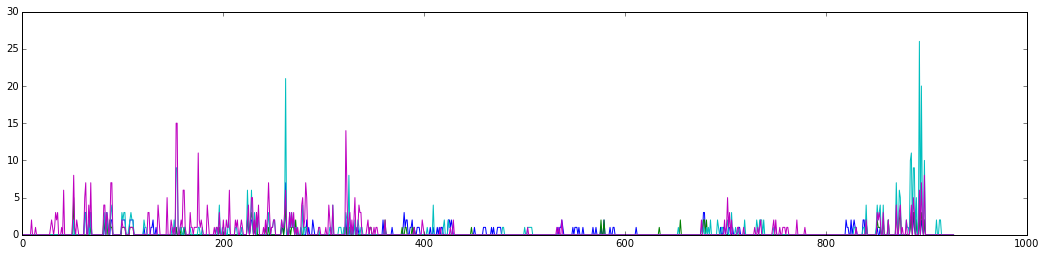

50


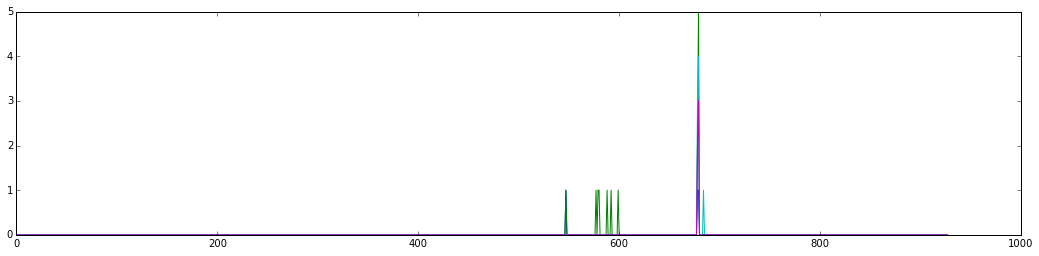

KeyboardInterrupt: 

In [89]:
end=datetime(2015,5,1,0)
timestep=3600
dt=timedelta(0,timestep)
db=MongoClient()
dbs=np.sort([x for x in db.database_names() if 'fl_car_roma' in x])


for cat in cats:
    start=datetime(2015,3,1,0)
    H=np.zeros((len(grid),24*len(dbs)))
    k=0
    #for current_db in dbs:
    for current_db in dbs[:2]:
        #for i in range(24):
        for i in range(2):
            cur=db[current_db]['floating_car_data'].find({'$and':[{'timestamp':{"$gte":start+i*dt}},{'timestamp':{"$lt":start+(i+1)*dt}},{'vehicle_cat': cat}]})
            curcount=cur.count()
            positions=np.zeros((curcount,2))
            travel_ids=np.empty(curcount,dtype='object')
            square_ids=np.zeros(curcount,dtype='object')
            h=0
            for c in cur:
                positions[h]=np.array([c['long'],c['lat']])
                travel_ids[h]=c['travel_id']
                h+=1
            for jj in range(len(positions)):
                for ii  in range(len(grid)):
                    if Polygon(grid[ii]).contains(Point(positions[jj])):
                        square_ids[jj]=ids[ii]
                        break
            unique_square_ids=list(set(square_ids))
            for u in unique_square_ids:
                I=np.where(ids==u)
                II=np.where(square_ids==u)
                H[I,k*24+i]=len(set(travel_ids[II]))
            
        start+=timedelta(1,0)
        k+=1
    
    out=open('features_dataset/unique_fl_cars_by_cell/_'+str(cat),'w')
    start=datetime(2015,3,1,0)
    for i in range(len(grid)):
        for j in range(len(H[i])):
            out.write(str(start+j*dt)+','+str(ids[i])+','+str(H[i,j])+',\n')
    out.close()
    print(cat)
    plt.figure(figsize=(18,4))
    plt.plot(H)
    plt.show()
'''    
H=np.zeros(24*len(dbs))
k=0
start=datetime(2015,3,1,0)
for current_db in dbs:
    for i in range(24):
        cur=db[current_db]['floating_car_data'].find({'$and':[{'timestamp':{"$gte":start+i*dt}},{'timestamp':{"$lt":start+(i+1)*dt}}]})
        positions=np.zeros((cur.count,2))
        travel_ids=np.empty(cur.count,dtype='object')
        square_ids=np.zeros(cur.count,dtype='object')
        h=0
        for c in cur:
            positions[h]=np.array([c['long'],c['lat']])
            travel_ids[h]=c['travel_id']
            h+=1
        for jj in range(len(positions)):
            for ii  in range(len(grid)):
                if Polygon(grid[ii]).contains(Point(positions[jj])):
                    square_ids[jj]=ids[ii]
                    break
        unique_square_ids=list(set(square_ids))
        for u in unique_square_ids:
            I=np.where(ids==u)
            II=np.where(square_ids==u)
            H[I,k*24+i]=len(set(travel_ids[II]))
    start+=timedelta(1,0)
    k+=1

out=open('features_dataset/unique_floating_car_by_cell','w')
start=datetime(2015,3,1,0)
for i in range(len(grid)):
    for j in range(len(H[i])):
        out.write(str(start+j*dt)+','+str(ids[i])+','+str(H[i,j])+',\n')
out.close()'''

In [80]:
len(travel_ids)

753

In [81]:
I

(array([829]),)

In [84]:
np.where(ids==u)

(array([829]),)

In [85]:
len(grid)

928

In [86]:
len(H)

928

In [88]:
travel_ids[np.where(square_ids==u)]

array([u'ac1e5d9114c1a40fd2d912052a6b3cfc',
       u'ac1e5d9114c1a40fd2d912052a6b3cfc',
       u'ac1e5d9114c1a40fd2d912052a6b3cfc',
       u'ac1e5d9114c1a40fd2d912052a6b3cfc',
       u'ac1e5d9114c1a40fd2d912052a6b3cfc'], dtype=object)